## Introduction
There's a common agreement that home-field advantage is big in college and professional football. As a fantasy player, I was curious if the relationship existed in fantasy as well. While there are certain star players that fantasy owners should start no matter the circumstances of the game, it is very difficult to choose a flex player each week (an additional starter that is typically less productive than your other starters, so assigning this position is a bit of luck). Should you aim for using flex players that have home-field advantage? If you need a backup for the week, are home players a better choice, and for which positions? I attempt to answer these questions in this project.

In [101]:
from bs4 import BeautifulSoup
import pandas as pd
import requests

In [102]:
# Params: limit - number of players to be included in the dataframe.
#         url - url to page of PFR fantasy leaders for any year.
# Returns : Dataframe containing each player's name, position, and stat page stub.
def getPlayers(url, limit):
    names = []
    position = []
    stubs = []
    # First we grab the URL and read in all tables from it.
    r = requests.get(url)
    soup = BeautifulSoup(r.content, 'html.parser')
    parsedTable = soup.find_all('table')[0]
        
    # First 2 rows in PFR's table are headers so skip them with [2:]
    for i, row in enumerate(parsedTable.find_all('tr')[2:]):
        # Some of the rows are just page breaks that we don't count, so we must
        # use the size of one of the arrays to keep track of our limit
        if len(names) == limit: break; 
        
        dat = row.find('td', attrs={'data-stat': 'player'})
        pos = row.find('td', attrs={'data-stat': 'fantasy_pos'})
        # We get the name of the player, his position, and the stub for the url.
        if (dat is not None):
            names.append(dat.a.get_text().strip('*+').rstrip())
            position.append(pos.get_text())
            stubs.append(dat.a.get('href'))
                
    return pd.DataFrame({'Name': names, 'Position': position, 'Stub': stubs})

In [103]:
df = getPlayers("https://www.pro-football-reference.com/years/2019/fantasy.htm", 200)

In [104]:
# The URL index for a fantasy page is /players/B/BradTo00/fantasy/year
# We just need to cut the htm and add that last part.
df['Stub'] = df['Stub'].apply(lambda x: x[:-4] + '/fantasy/2019')

In [105]:
df

,Name,Position,Stub
0,Christian McCaffrey,RB,/players/M/McCaCh01/fantasy/2019
1,Lamar Jackson,QB,/players/J/JackLa00/fantasy/2019
2,Derrick Henry,RB,/players/H/HenrDe00/fantasy/2019
3,Aaron Jones,RB,/players/J/JoneAa00/fantasy/2019
4,Ezekiel Elliott,RB,/players/E/ElliEz00/fantasy/2019
...,...,...,...
195,Tajae Sharpe,WR,/players/S/SharTa00/fantasy/2019
196,Eric Ebron,TE,/players/E/EbroEr00/fantasy/2019
197,Ted Ginn Jr.,WR,/players/G/GinnTe00/fantasy/2019
198,Nelson Agholor,WR,/players/A/AghoNe00/fantasy/2019


In [106]:
#Assigns a Home or Away value based on the character.
def homeOrAway(x):
    if x == '@': 
        return 'Away'
    else: 
        return 'Home'
    
# Creates and returns a game log from a list of players.
# Each entry contains the player's name, position, if the game is home or away,
# and the number of fantasy points the player scored.
def getPointLogs(players):
    names = []
    positions = []
    field = []
    pointTotals = []
    
    for i, player in players.iterrows():
        table = pd.read_html('https://www.pro-football-reference.com' + player['Stub'])[0]
        # A little clean-up here. Drop the top 2 levels so indexing is a little easier.
        # Then we take the away/home column that PFR left unnamed and change that from
        # '@'s and blank entries to 1 and 0 for home and away. 
        table.columns = table.columns.droplevel().droplevel()
        table['Unnamed: 4_level_2'] = table['Unnamed: 4_level_2'].apply(lambda x: homeOrAway(x))
        
        for j, row in table.iterrows():
            # The last row table is the season totals. Don't include it.
            if j != len(table) - 1:
                names.append(player['Name'].strip('*+'))
                positions.append(player['Position'])
                field.append(row['Unnamed: 4_level_2'])
                pointTotals.append(row['FantPt'])
            
    return pd.DataFrame({'Name': names, 'Position': positions, 'Points': pointTotals, 'Field': field, })

In [107]:
pointLogs = getPointLogs(df)

In [108]:
# Need to get rid of games with no points
pointLogs = pointLogs.dropna()
pointLogs

,Name,Position,Points,Field
0,Christian McCaffrey,RB,32.9,Home
1,Christian McCaffrey,RB,5.3,Home
2,Christian McCaffrey,RB,24.8,Away
3,Christian McCaffrey,RB,23.9,Away
4,Christian McCaffrey,RB,41.7,Home
...,...,...,...,...
2810,Cameron Brate,TE,0.5,Away
2811,Cameron Brate,TE,9.0,Home
2812,Cameron Brate,TE,3.3,Away
2813,Cameron Brate,TE,1.7,Home


# Analysis

In [109]:
import seaborn as sns
import matplotlib.pyplot as plt

**QBs, WRs, and TEs all have a higher mean for home games, although the differences seem rather small.**


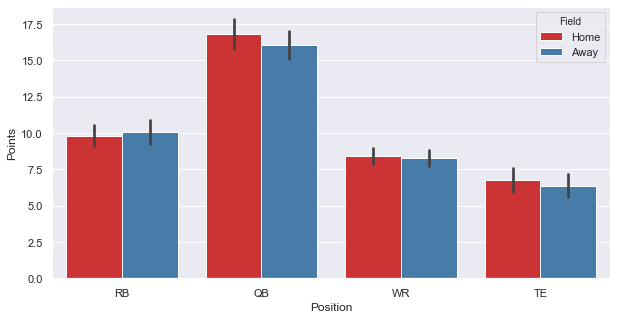

In [110]:
sns.set(style='darkgrid', rc={'figure.figsize':(10,5)}, palette='Set1')
#fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x='Position', y='Points', data=pointLogs, hue='Field')

**Looking at the distributions, the median for QBs is nearly exact for home and away, but the range is a bit larger and there are much more outlier games (or 'boom' games for fantasy) at home. The distribution for the WRs shows a bit smaller interquartile range for away but still several outlier games. The TEs are consistent with the last plot, they perform slightly better at home.**  

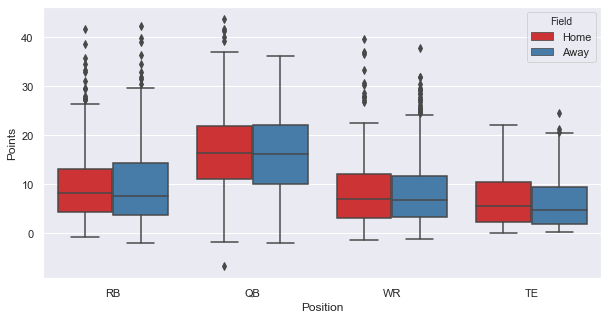

In [111]:
sns.boxplot(x='Position', y='Points', data=pointLogs, hue='Field')

In [112]:
awayAvg = pointLogs[pointLogs['Field'] == 'Away'].groupby('Position').mean()
homeAvg = pointLogs[pointLogs['Field'] == 'Home'].groupby('Position').mean()
pointDiffs = pd.DataFrame({'Home_Average': homeAvg['Points'], 
                           'Away_Average': awayAvg['Points'], 'Difference': homeAvg['Points'] - awayAvg['Points']})

**Our differences are very small, with none over 1.0 and only one over .5. Perhaps some players vary more than others, let's see who's most sensitive to home field advantage.**

In [113]:
pointDiffs

,Home_Average,Away_Average,Difference
Position,,,
QB,16.811074,16.070787,0.740287
RB,9.818392,10.054386,-0.235994
TE,6.769753,6.322353,0.447400
WR,8.419887,8.261051,0.158837


In [114]:
homePlayerAvg = pointLogs[pointLogs['Field'] == 'Home'].groupby('Name').mean()
awayPlayerAvg = pointLogs[pointLogs['Field'] == 'Away'].groupby('Name').mean()
playerDiffs = pd.DataFrame({'Home_Average': homePlayerAvg['Points'], 
                           'Away_Average': awayPlayerAvg['Points'], 
                            'Difference': homePlayerAvg['Points'] - awayPlayerAvg['Points']})

In [115]:
# Sorting the dataframe by the absolute value of difference. 
playerDiffs = playerDiffs.reindex(playerDiffs.Difference.abs().sort_values(ascending=False).index)
playerDiffs.head(10)

,Home_Average,Away_Average,Difference
Name,,,
Jeff Driskel,27.460000,14.820000,12.640000
Evan Engram,4.100000,14.966667,-10.866667
Daniel Jones,11.306667,21.020000,-9.713333
Darius Slayton,5.057143,14.433333,-9.376190
Drew Brees,24.663333,15.356000,9.307333
Dwayne Haskins,13.615000,4.448000,9.167000
Josh Jacobs,17.271429,8.450000,8.821429
Chase Edmonds,4.060000,12.650000,-8.590000
Will Fuller,12.160000,4.033333,8.126667


## Are these players actually better at home or away?

**If we take a look at guys like Jeff Driskel and Evan Engram, some of them are just due to imbalance. (Engram played 5 home games and 3 away due to injuries, Driskel is a backup and only played 3 games with the 1 home game being much better than the 2 away)**

In [120]:
pointLogs[pointLogs['Name'] == 'Jeff Driskel']

,Name,Position,Points,Field
2717,Jeff Driskel,QB,17.06,Away
2718,Jeff Driskel,QB,27.46,Home
2719,Jeff Driskel,QB,12.58,Away


In [122]:
pointLogs[pointLogs['Name'] == 'Evan Engram']

,Name,Position,Points,Field
2553,Evan Engram,TE,17.6,Away
2554,Evan Engram,TE,4.8,Home
2555,Evan Engram,TE,17.3,Away
2556,Evan Engram,TE,5.4,Home
2557,Evan Engram,TE,4.7,Home
2558,Evan Engram,TE,0.6,Home
2559,Evan Engram,TE,10.0,Away
2560,Evan Engram,TE,5.0,Home


**Others, like Will Fuller and Drew Brees, are skewed due to a couple really good or really bad games.**

In [118]:
pointLogs[pointLogs['Name'] == 'Will Fuller']

,Name,Position,Points,Field
2072,Will Fuller,WR,6.9,Away
2073,Will Fuller,WR,4.0,Home
2074,Will Fuller,WR,5.1,Away
2075,Will Fuller,WR,2.3,Home
2076,Will Fuller,WR,39.7,Home
2077,Will Fuller,WR,4.4,Away
2078,Will Fuller,WR,0.6,Away
2079,Will Fuller,WR,14.0,Home
2080,Will Fuller,WR,0.8,Home
2081,Will Fuller,WR,6.1,Away


In [119]:
pointLogs[pointLogs['Name'] == 'Drew Brees']

,Name,Position,Points,Field
1295,Drew Brees,QB,20.80,Home
1296,Drew Brees,QB,-0.48,Away
1297,Drew Brees,QB,24.92,Home
1298,Drew Brees,QB,11.48,Home
1299,Drew Brees,QB,21.12,Away
1300,Drew Brees,QB,22.44,Home
1301,Drew Brees,QB,11.26,Away
1302,Drew Brees,QB,40.06,Home
1303,Drew Brees,QB,28.28,Home
1304,Drew Brees,QB,22.86,Away


**Darius Slayton actually seems to play better away somewhat consistently. Josh Jacobs is the opposite, he booms during home games.**

In [96]:
pointLogs[pointLogs['Name'] == 'Darius Slayton']

,Name,Position,Points,Field
1545,Darius Slayton,WR,8.2,Away
1546,Darius Slayton,WR,1.3,Home
1547,Darius Slayton,WR,12.2,Home
1548,Darius Slayton,WR,3.2,Away
1549,Darius Slayton,WR,2.8,Home
1550,Darius Slayton,WR,17.0,Away
1551,Darius Slayton,WR,0.6,Home
1552,Darius Slayton,WR,24.1,Away
1553,Darius Slayton,WR,6.7,Away
1554,Darius Slayton,WR,4.4,Home


In [124]:
pointLogs[pointLogs['Name'] == 'Josh Jacobs']

,Name,Position,Points,Field
532,Josh Jacobs,RB,23.3,Home
533,Josh Jacobs,RB,9.9,Home
534,Josh Jacobs,RB,4.4,Away
535,Josh Jacobs,RB,10.8,Away
536,Josh Jacobs,RB,26.3,Home
537,Josh Jacobs,RB,13.4,Away
538,Josh Jacobs,RB,8.1,Away
539,Josh Jacobs,RB,24.0,Home
540,Josh Jacobs,RB,16.1,Home
541,Josh Jacobs,RB,10.4,Home


# Conclusions 

**Players are slightly better at home than away.**
- The difference for each position was less than 1.0. Games can definitely come down to fractions of a point, but this difference isn't significant enough to trump other factors.

**Boom games happen at home more often for QBs.**
- There are more outlier games for QBs at home.
- The home mean is only .74 higher than the away mean. If you're desperate for a big game from the QB, the home player may be the way to go, but in most cases it may not be a huge factor.

**QBs are overall the most affected by home-field advantage.**
- Not a very shocking find. QBs have to call plays and audibles right before the ball is snapped. Away crowds are purposely loud in crucial moments to make it harder for the QB to communicate. Home QBs may be more likely to execute well in those cruical moments.

**A player-by-player analysis may be more useful for finding patterns.**
- We saw Josh Jacobs and Darius Slayton did better at home and away, respectively.
- There's probably plenty of other players who follow some sort of pattern as well, or general teams.
- The pointsLog dataframe has been saved and posted under this project if you'd like to analyze!
